#### Import


In [401]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

##### Тут мы загрузим и посмотрим на датасет.

In [402]:
DATA_PATH_TRAIN = "data/train.csv"
df = pd.read_csv(DATA_PATH_TRAIN)
DATA_PATH_TEST = "data/test.csv"
test = pd.read_csv(DATA_PATH_TEST)
df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


##### Ящики с усами для удаления выбросов.

С их помощью мы определим выбросы в данных. Да и вообще в целом оценим распределение.

Plotting box plot for: Age
Plotting box plot for: AnnualIncome
Plotting box plot for: CreditScore
Plotting box plot for: LoanAmount
Plotting box plot for: LoanDuration
Plotting box plot for: NumberOfDependents
Plotting box plot for: MonthlyDebtPayments
Plotting box plot for: CreditCardUtilizationRate
Plotting box plot for: NumberOfOpenCreditLines
Plotting box plot for: NumberOfCreditInquiries
Plotting box plot for: DebtToIncomeRatio
Plotting box plot for: BankruptcyHistory
Plotting box plot for: PreviousLoanDefaults
Plotting box plot for: PaymentHistory
Plotting box plot for: LengthOfCreditHistory
Plotting box plot for: SavingsAccountBalance
Plotting box plot for: CheckingAccountBalance
Plotting box plot for: TotalAssets
Plotting box plot for: TotalLiabilities
Plotting box plot for: MonthlyIncome
Plotting box plot for: UtilityBillsPaymentHistory
Plotting box plot for: JobTenure
Plotting box plot for: Experience
Plotting box plot for: NetWorth
Plotting box plot for: BaseInterestRate
Plo

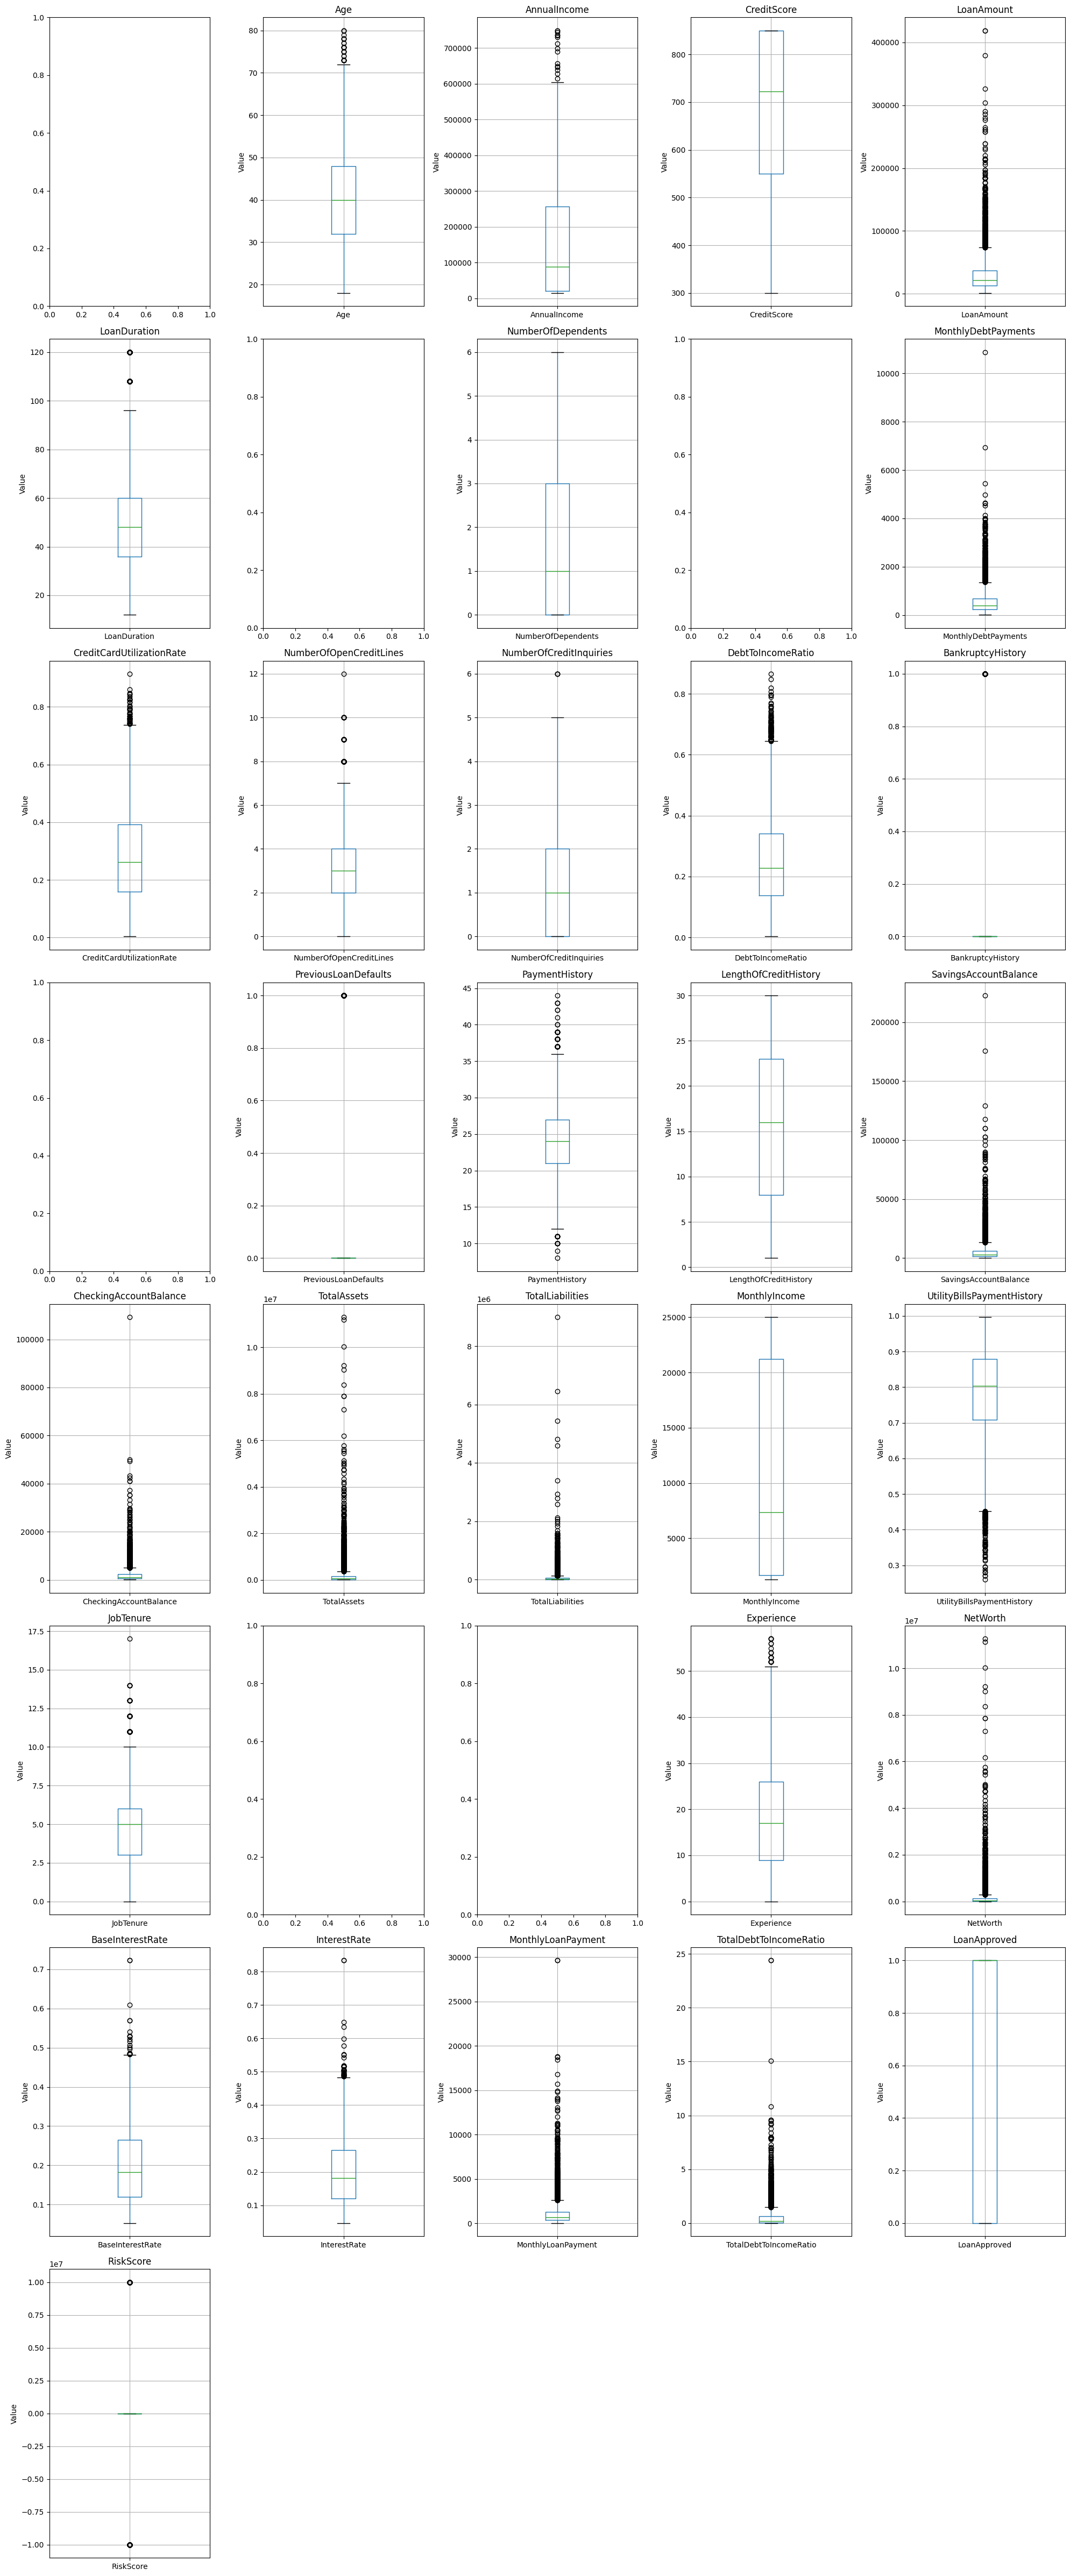

In [403]:
num_columns = len(df.columns)
nrows = 8

fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(20, 6*nrows))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    if pd.api.types.is_numeric_dtype(df[col]):
        print(f'Plotting box plot for: {col}')
        try:
            df.boxplot(column=col, ax=axes[i])
            axes[i].set_title(col)
            axes[i].set_ylabel('Value')
        except Exception as e:
            print(f'Error plotting {col}: {e}')  # Для отладки

# Удаление пустых осей, если количество признаков меньше, чем оси
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### Пропущенные данные

Обнаруживаем пропуски в данных, замечаем определенную закономерность.

<Axes: >

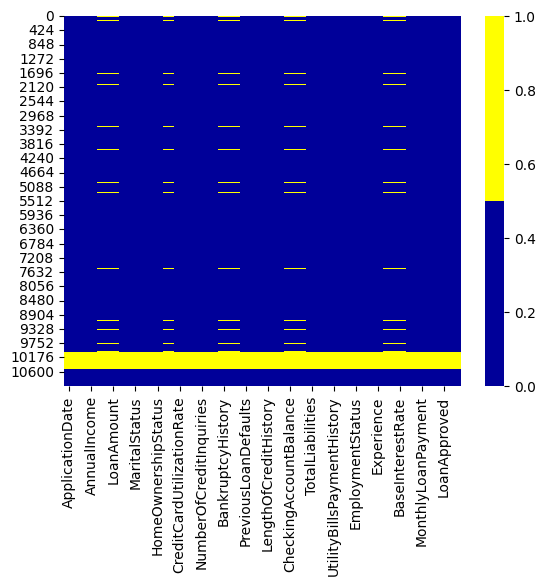

In [404]:
cols = df.columns
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

##### Нормализация и трансформация данных.

Тут я пишу всякие нормализаторы и трансфоматоры, которые в процессе буду использовать на данных.

In [405]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

###### Логарифмический нормализатор.
Необходим для нормализации данных с экспоненциальным распределением. И для данных со смещенным нормальный распределением.

In [406]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(np.log1p(X))

###### One-hot encoder трансформатор.

In [407]:
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        dummies = pd.get_dummies(X[self.columns], drop_first=True)
        X = pd.concat([X.drop(columns=self.columns), dummies], axis=1)
        return X

###### Удаление целевой переменной.

In [408]:
class DropTargetColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.drop(columns=[self.X])
        else:
            raise ValueError("Input should be a pandas DataFrame")

###### Разбор даты в данных.

In [409]:
class DateProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, date_column):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column], format='%Y-%m-%d')
        X['application_year'] = X[self.date_column].dt.year
        X['application_month'] = X[self.date_column].dt.month
        X['application_day_of_week'] = X[self.date_column].dt.dayofweek
        
        X = X.drop(self.date_column, axis=1)
        
        return X

###### Преобразование булевых столбцов в числовые.

In [410]:
class BoolToIntTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.select_dtypes(include=[bool]).columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()

        bool_columns = []
        if self.columns is None:
            bool_columns = X.select_dtypes(include=[bool]).columns
        else:
            bool_columns = [col for col in self.columns if col in X.columns and X[col].dtype == 'bool']
            missing_columns = [col for col in self.columns if col not in X.columns]
            if missing_columns:
                print(f"Warning: The following columns do not exist in the DataFrame and will be ignored: {missing_columns}")
        X[bool_columns] = X[bool_columns].astype(int)
        return pd.DataFrame(X)

###### Удаление определенных столбцов.

In [411]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.columns_to_drop, errors='ignore')

###### Удаление выбросов за пределами определенных квантилей.

In [412]:
class IQRDropoutTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, multiplier=1.5):
        self.columns = columns
        self.multiplier = multiplier

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        if self.columns is None:
            columns = X.select_dtypes(include=[np.number]).columns
        else:
            columns = self.columns
        
        for column in columns:
            if column in X.columns:

                Q1 = X[column].quantile(0.25)
                Q3 = X[column].quantile(0.75)
                IQR = Q3 - Q1

                lower_bound = Q1 - self.multiplier * IQR
                upper_bound = Q3 + self.multiplier * IQR

                X = X[(X[column] >= lower_bound) & (X[column] <= upper_bound)]
        
        return X

###### Удаление дубликатов и пропусков. 

In [413]:
class DropDuplicatesAndNaNTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X = X.copy()
        X = X.drop_duplicates()
        X = X.dropna()
        return pd.DataFrame(X) 

###### Удаление данных со странным RiskScore'ом.

In [414]:
class RiskScoreFilter(BaseEstimator, TransformerMixin):
    def __init__(self, column='RiskScore', min_value=-10000, max_value=10000):
        self.column = column
        self.min_value = min_value
        self.max_value = max_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = X[(X[self.column] >= self.min_value) & (X[self.column] <= self.max_value)]
        return pd.DataFrame(X)

###### Выбор колонок, где что будем делать.

In [415]:
standart_columns = ['LoanDuration', 'PaymentHistory', 'JobTenure']

minimax_columns = ['NumberOfDependents', 'LengthOfCreditHistory', 'application_year', 'application_month', 'application_day_of_week']

log_columns = ['AnnualIncome', 'MonthlyDebtPayments', 'NumberOfCreditInquiries', 'SavingsAccountBalance', 'UtilityBillsPaymentHistory',
                  'CheckingAccountBalance', 'TotalLiabilities', 'NetWorth', 'CreditCardUtilizationRate', 'DebtToIncomeRatio', 'CreditScore', 'AnnualIncome',
                  'InterestRate', 'BaseInterestRate', 'TotalDebtToIncomeRatio', 'LoanAmount', 'Experience', 'MonthlyIncome', 'BaseInterestRate', 'InterestRate', 
                  'MonthlyLoanPayment', 'TotalAssets', 'AnnualIncome', 'NumberOfOpenCreditLines']

one_hot_features = ['MaritalStatus', 'HomeOwnershipStatus', 'EducationLevel', 'EmploymentStatus', 'LoanPurpose']

data_column = ['ApplicationDate']

target_column = ['RiskScore']

skip_features = ['Experience', 'MonthlyIncome', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalAssets', "AnnualIncome"]

corr_in_some_way = ['Experience', 'MonthlyIncome', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalAssets', "AnnualIncome"] # annual income + CreditScore
    

###### Создание трансформеров и их применение.

In [416]:
def filter_columns(columns, exclude):
    return [col for col in columns if col not in exclude]

preprocessor = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', LogTransformer()),
            ('scaler', StandardScaler())
        ]), filter_columns(log_columns, skip_features)),
        ('standart', StandardScaler(), filter_columns(standart_columns, skip_features)),
        ('minimax', MinMaxScaler(), filter_columns(minimax_columns, skip_features)),
    ],
    remainder='passthrough'
)

###### Тестирование и обучение модели при помощи поиска по сетке.

In [417]:
class LinearClassifier:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # Initialize weights and bias
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (linear_model - y))
            db = (1 / n_samples) * np.sum(linear_model - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return np.where(linear_model >= 0.5, 1, 0)
    
class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return np.where(y_predicted >= 0.5, 1, 0)


In [418]:
def preprocess_data(X, transformers):
    X = X.copy()
    for transformer in transformers:
        X = transformer.transform(X)
    return X

# Применение функции с указанием трансформеров
transformers = [
    DropDuplicatesAndNaNTransformer(),
    DateProcessor(data_column[0]),
    GetDummiesTransformer(one_hot_features),
    RiskScoreFilter('RiskScore', min_value=-10000, max_value=10000),
    DropColumnsTransformer(corr_in_some_way),
    BoolToIntTransformer(df.columns)
]

transformers_test = [
    DropDuplicatesAndNaNTransformer(),
    DateProcessor(data_column[0]),
    GetDummiesTransformer(one_hot_features),
    DropColumnsTransformer(corr_in_some_way),
    BoolToIntTransformer(df.columns),
]

df_cleaned = preprocess_data(df, transformers)

Y_train = df_cleaned['LoanApproved']
df_cleaned = df_cleaned.drop(['LoanApproved', 'RiskScore'], axis=1)
X_train = preprocessor.fit_transform(df_cleaned)

df_test_clean = preprocess_data(test, transformers_test)
Y_test = df_test_clean['LoanApproved']
X_test = df_test_clean.drop('LoanApproved', axis=1)
X_test = preprocessor.transform(df_test_clean)

In [419]:
def preprocess_data(X, transformers):
    X = X.copy()
    for transformer in transformers:
        X = transformer.transform(X)
    return X

# Применение функции с указанием трансформеров
transformers = [
    DropDuplicatesAndNaNTransformer(),
    DropColumnsTransformer(corr_in_some_way),
    DateProcessor(data_column[0]),
    GetDummiesTransformer(one_hot_features),
    RiskScoreFilter('RiskScore', min_value=-10000, max_value=10000),
    BoolToIntTransformer(df.columns)
]

transformers_test = [
    DropDuplicatesAndNaNTransformer(),
    DropColumnsTransformer(corr_in_some_way),
    DateProcessor(data_column[0]),
    GetDummiesTransformer(one_hot_features),
    BoolToIntTransformer(df.columns),
]

df_cleaned = preprocess_data(df, transformers)

Y_train = df_cleaned['LoanApproved']
df_cleaned = df_cleaned.drop(['LoanApproved', 'RiskScore'], axis=1)
X_train = preprocessor.fit_transform(df_cleaned)

df_test_clean = preprocess_data(test, transformers_test)
Y_test = df_test_clean['LoanApproved']
X_test = df_test_clean.drop('LoanApproved', axis=1)
X_test = preprocessor.transform(df_test_clean)

/tmp/ipykernel_9771/429866868.py:20: RuntimeWarning: invalid value encountered in subtract
  self.weights -= self.learning_rate * dw


Linear Classifier Accuracy: 0.4838
Logistic Regression Accuracy: 0.9092
Logistic Regression Results:
Precision: 0.8891
Recall: 0.9415
F1 Score: 0.9146
Accuracy: 0.9092



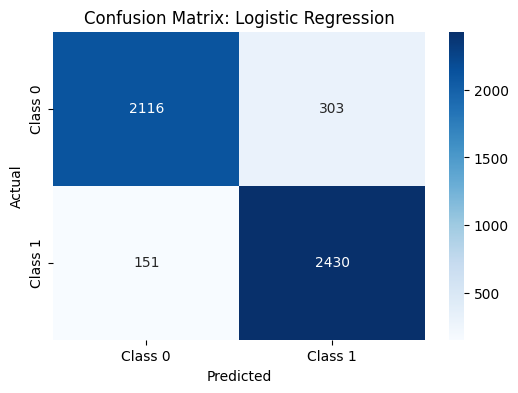

SVM Results:
Precision: 0.7852
Recall: 0.9744
F1 Score: 0.8696
Accuracy: 0.8492



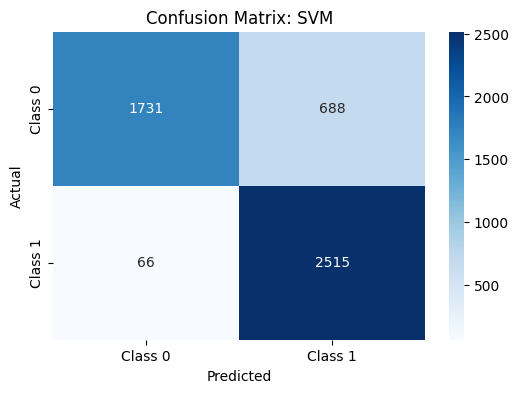

Decision Tree Results:
Precision: 0.8944
Recall: 0.8958
F1 Score: 0.8951
Accuracy: 0.8916



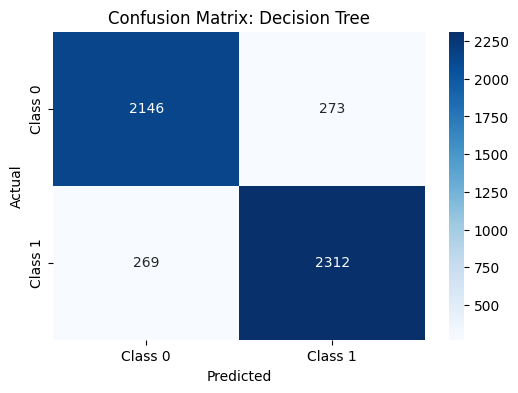

Random Forest Results:
Precision: 0.8940
Recall: 0.9310
F1 Score: 0.9121
Accuracy: 0.9074



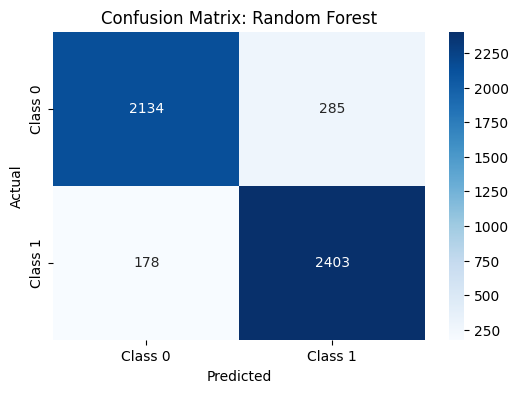

Gradient Boosting Results:
Precision: 0.9163
Recall: 0.9372
F1 Score: 0.9266
Accuracy: 0.9234



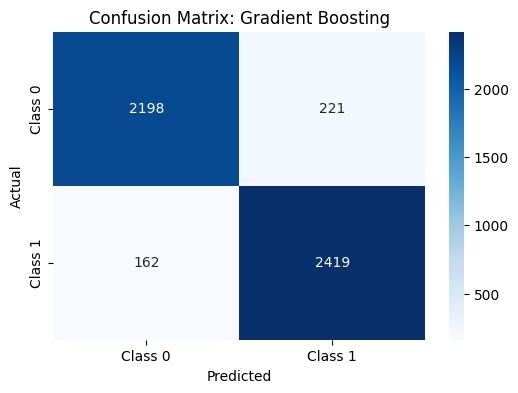

[LightGBM] [Info] Number of positive: 4789, number of negative: 4543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 9332, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513180 -> initscore=0.052734
[LightGBM] [Info] Start training from score 0.052734
LightGBM Results:
Precision: 0.9210
Recall: 0.9345
F1 Score: 0.9277
Accuracy: 0.9248



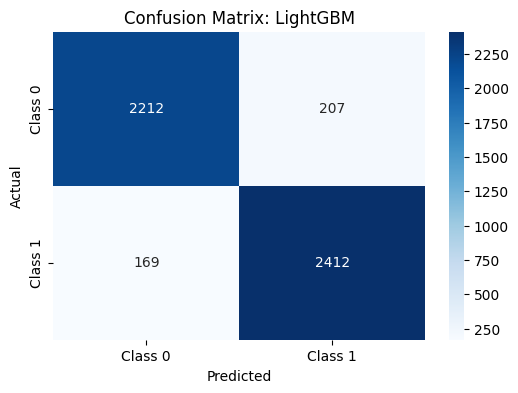

XGBoost Results:
Precision: 0.9231
Recall: 0.9349
F1 Score: 0.9290
Accuracy: 0.9262



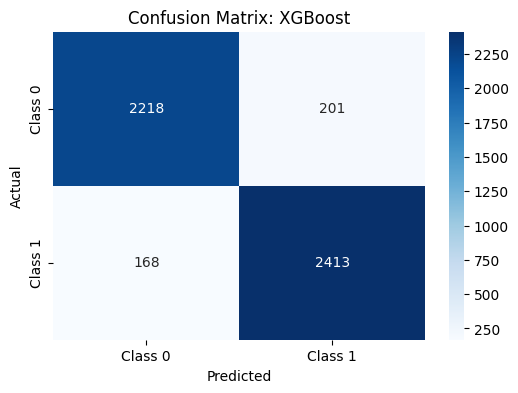

CatBoost Results:
Precision: 0.9242
Recall: 0.9407
F1 Score: 0.9324
Accuracy: 0.9296



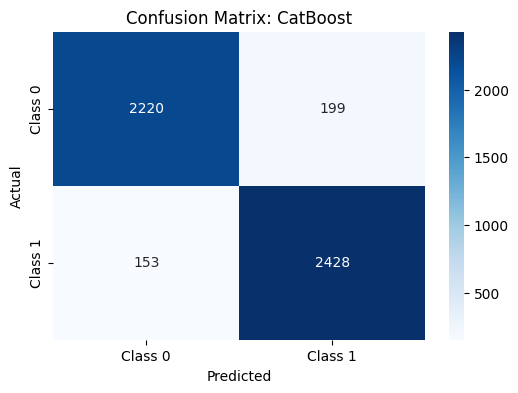

In [424]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb


linear_clf = LinearClassifier(learning_rate=0.01, n_iters=1000)
linear_clf.fit(X_train, Y_train)
predictions = linear_clf.predict(X_test)
print("Linear Classifier Accuracy:", np.mean(predictions == Y_test))

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, Y_train)
predictions = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", np.mean(predictions == Y_test))
print()
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Storage for results
results = {}

for name, model in models.items():
    # Train model
    model.fit(X_train, Y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    accuracy = accuracy_score(Y_test, y_pred)
    cm = confusion_matrix(Y_test, y_pred)

    # Save results
    results[name] = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Accuracy": accuracy,
        "Confusion Matrix": cm
    }

    # Display metrics
    print(f"{name} Results:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}\n")

    # Confusion Matrix Visualization
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

Выводы:
Результаты показывают, что модели демонстрируют почти одинаковый уровень производительности на одном и том же наборе данных. SVM показало худший результат из всех. Далее идут решающие деревья, случайный лес и логистическая регрессия. Лучшие всего себя показали различные бустинги. Эти модели предоставляют высокую точность и F1-меру благодаря их способности учитывать сложные нелинейные зависимости.

F1 Score оказался наиболее информативной метрикой. В задаче бинарной классификации, особенно при потенциальном несбалансированном классовом распределении, F1 Score лучше всего отражает компромисс между точностью (precision) и полнотой (recall).

Confusion Matrix помогает понять не только общую производительность модели, но и типичные ошибки, такие как неверная классификация класса 0 как класса 1 или наоборот. Она очень хорошо помогает определить, в чём конкретно слаба модель и какая у нее основная ошибка.

Логистическая регрессия все еще остается базовым, но полезным инструментом. Она обеспечила предсказуемую и интерпретируемую производительность, хотя и уступает более сложным моделям на этих данных.

Рекомендация: В зависимости от доступных вычислительных ресурсов и сложности данных рекомендуется начать с моделей Random Forest и Logistic Regression, а затем перейти к LightGBM или XGBoost для финальной оптимизации.

###### Вывод матрицы корреляций.

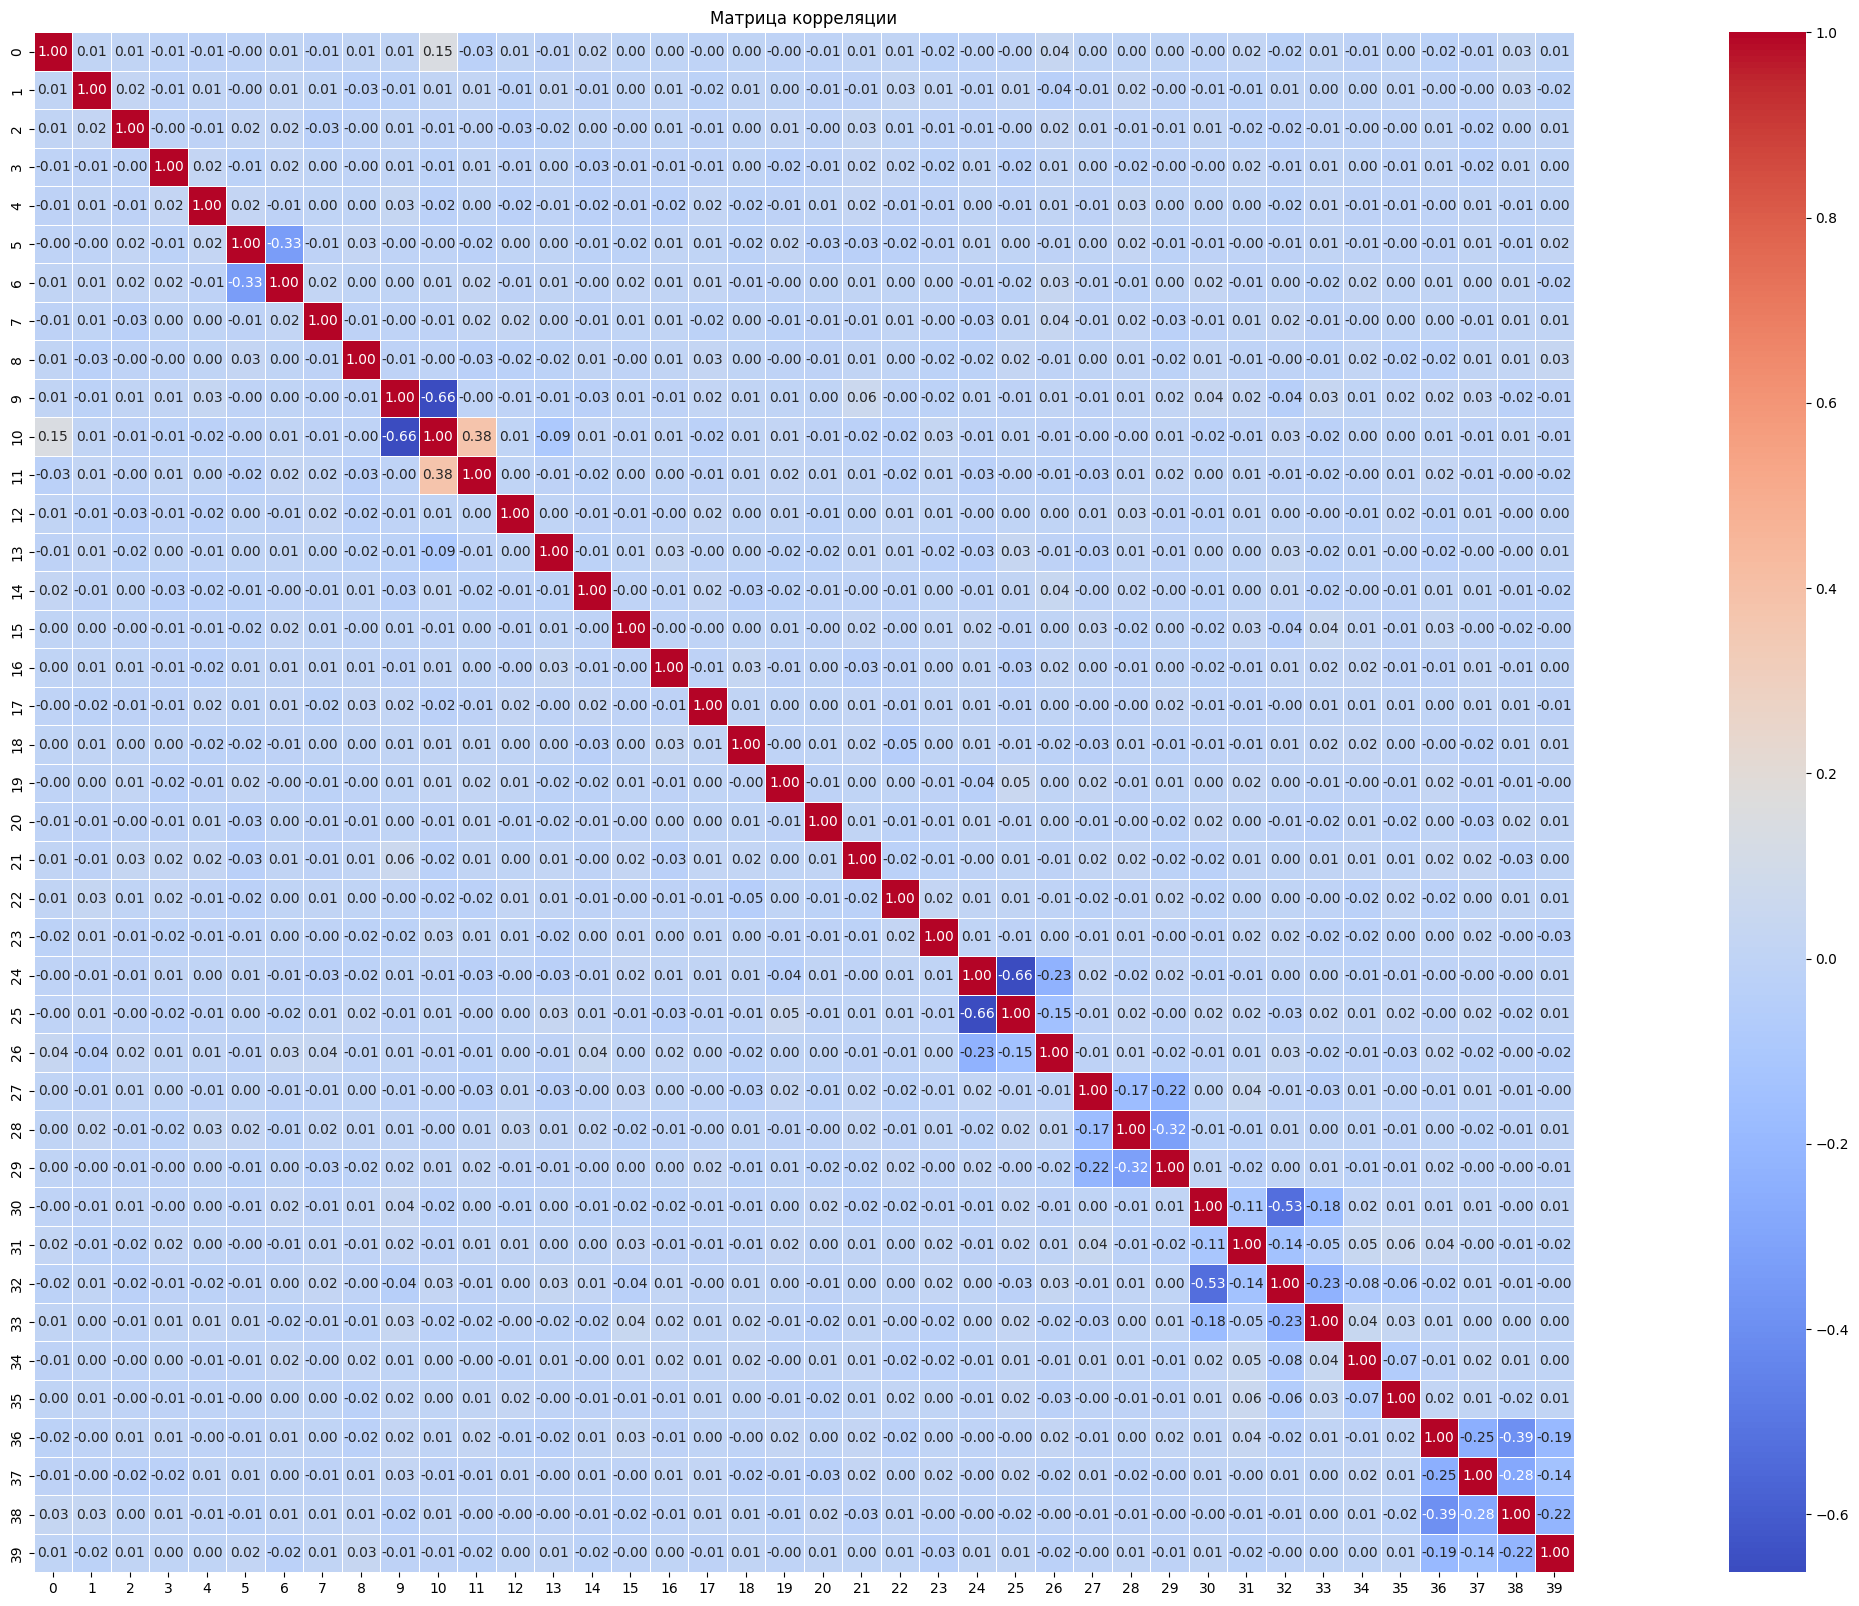

In [421]:
correlation_matrix = pd.DataFrame(X_test).corr()
plt.figure(figsize=(40, 20))  # Установите размер графика
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f', linewidths=.5)
plt.title('Матрица корреляции')
plt.show()

###### Вывод диаграмм для определение распределения.

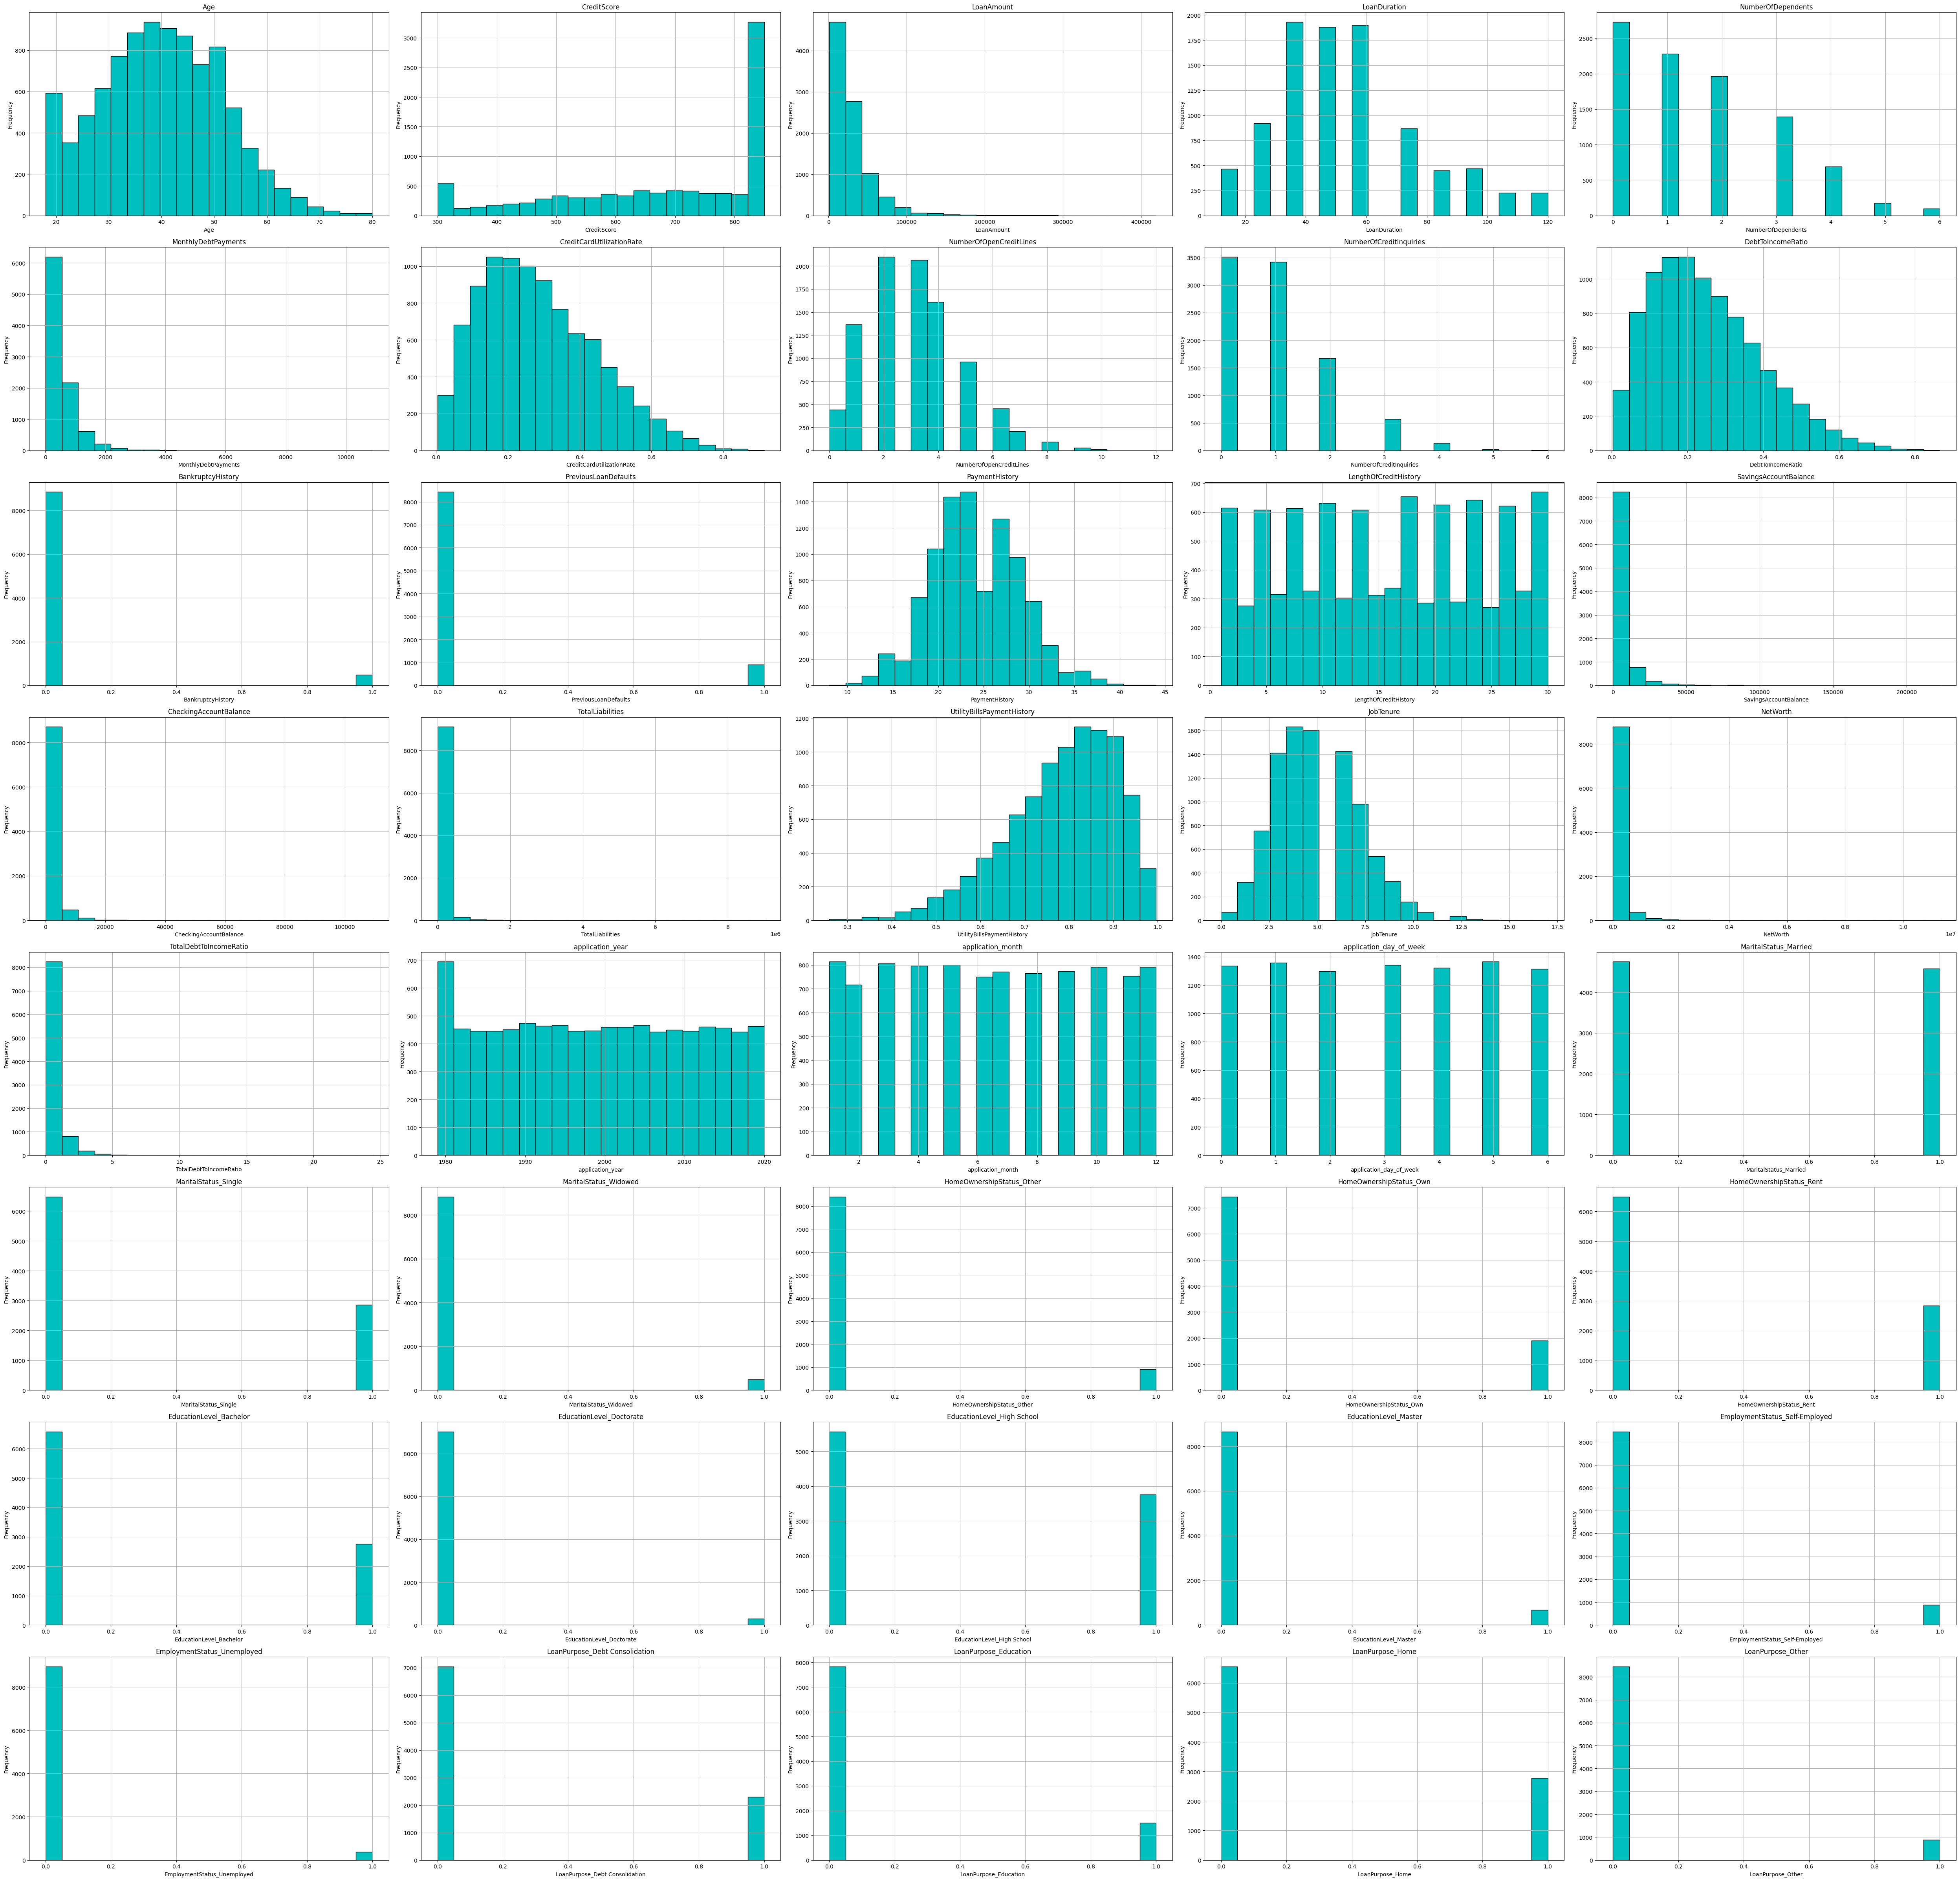

In [422]:
num_columns = len(df_cleaned.columns)

nrows = 8

fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(50, 6*nrows))

axes = axes.ravel()

for i, col in enumerate(df_cleaned.columns):
    if pd.api.types.is_numeric_dtype(df_cleaned[col]):
        try:
            df_cleaned[col].hist(ax=axes[i], bins=20, color='c', edgecolor='black')
            axes[i].set_title(col)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
        except Exception as e:
            print(f'Error plotting {col}: {e}')  # Для отладки

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

###### Окончательное обучение модели и загрузка файлов в csv.

In [423]:
# models['Ridge'].fit(X_proc, Y)

# transformers_test = [
# DropDuplicatesAndNaNTransformer(),
#     DateProcessor(data_column[0]),
#     GetDummiesTransformer(one_hot_features),
#     # DropColumnsTransformer(corr_in_some_way),
#     BoolToIntTransformer(df.columns),
# ]

# df_test_clean = preprocess_data(test, transformers_test)
# df_test_clean = df_test_clean.drop('ID', axis=1)
# X_proc_test = preprocessor.transform(df_test_clean)

# to_kaggle = models['Ridge'].predict(X_proc_test)
# df_kaggle = pd.DataFrame({'ID': range(len(to_kaggle)), 'RiskScore': to_kaggle})
# df_kaggle.to_csv('submission.csv', index=False)